<a href="https://colab.research.google.com/github/bernhardbrugger/bernhardbrugger/blob/main/notebook9554d70c99_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **G-Research Crypto Forecasting**

The following notebook is a summary of the models developed for the **G-Research Crypto Forecasting Competition**
on Kaggle (https://www.kaggle.com/competitions). It covers most of the code written so far for this competition, but it does **not** cover all the data, since executing the entire script in one run would require more computation and storage ressources than available.


## Description of the Competition (https://www.kaggle.com/c/g-research-crypto-forecasting)

Over 40 billion dollar worth of cryptocurrencies are traded every day. They are among the most popular assets for speculation and investment, yet have proven wildly volatile. Fast-fluctuating prices have made millionaires of a lucky few, and delivered crushing losses to others. Could some of these price movements have been predicted in advance?

In this competition, you'll use your machine learning expertise to forecast short term returns in 14 popular cryptocurrencies. We have amassed a dataset of millions of rows of high-frequency market data dating back to 2018 which you can use to build your model. Once the submission deadline has passed, your final score will be calculated over the following 3 months using live crypto data as it is collected.

The simultaneous activity of thousands of traders ensures that most signals will be transitory, persistent alpha will be exceptionally difficult to find, and the danger of overfitting will be considerable. In addition, since 2018, interest in the cryptomarket has exploded, so the volatility and correlation structure in our data are likely to be highly non-stationary. The successful contestant will pay careful attention to these considerations, and in the process gain valuable insight into the art and science of financial forecasting.

G-Research is Europe’s leading quantitative finance research firm. We have long explored the extent of market prediction possibilities, making use of machine learning, big data, and some of the most advanced technology available. Specializing in data science and AI education for workforces, Cambridge Spark is partnering with G-Research for this competition. 

## Short description of my Model

### Model Architecture

#### Part 1: Model
For this competition, I chose **Stacking** (or Stacked Generalization) with different types of **Regressors**. In a nutshell, Stacking is an ensemble learning technique consisting of two layers, where the output of the first layer models are used as training input for the second layer model. The second layer training X_data is constructed by consecutively train regressors on (k - 1) folds and predict each round on the remaining fold. Afterwards, the new trainingdata is based on the predictions of each fold. The test X_data is the mean of k predictions of X_test. A short illustration of this process can be seen below:   


![Illustration of Stacking](https://i.imgur.com/QBuDOjs.jpg)


The first layer of my stacking model consists of four base regressors, i.e. **Random Forest**, **Extra Trees**, **Light Gradient Boosting Machines**, **Extreme Gradient Boosting Machines**. I will perform in-depth **Hyperparameter Search** in order to find the best parameter combinations. The second layer, i.e. the "top-level" regressor, uses the outcome predictions as input training data. The second layer in this work is a deep learning model called **Long Short Term Memory**. Note, that the combination of the first and second layer model(s) is still under experimentation, which means, that this might not be the best combination.

#### Part 2: Ressource Allocation Strategy 
Due to numerous time-consuming steps (especially the hyperparameter tuning), I also set up the following computation ressource allocation strategy in order to speed up extensive computiations:

* Hyperparameter search and the training of the first layer regressors is done with **Parallel Processing** using the Ray framework (https://www.ray.io/).

* The second layer deep learning model is performed with the help of **Google TPU** (i.e. Tensor Processing Unit), which are processing units especially made for solving deep learning problems (https://cloud.google.com/tpu).

#### Part 3: Storage-Optimization Strategy
As a consequence of the data size, I use the **gc (Garbage Collector) package** to follow a storage-optimization strategy by consistently delete unused datasets.

### Features

The original dataset provided by G-Research consists of minute-wise intraday data (with the columns: Asset_ID, Count, Open, High, Low, Close, Volume, Volume Weighted Average Price, and the Target) of 14 crypto currencies, namely:

* Bitcoin Cash
* Binance Coin
* Bitcoin
* EOS.IO
* Ethereum Classic
* Ethereum
* Litecoin
* Monero
* TRON
* Stellar
* Cardano
* IOTA
* Maker
* Dogecoin

I assume that crypto currencies, like "traditional" stock data, rely to some extend on **Technical Indicators**. Therefore, I add a lot of Technical Indicators as additional features (e.g. RSI, MACD, Bollinger Bands, Stochastic Oscillator, etc.). In addition, I also add general Time Features (e.g. day of the year, month of the year, weekdays, etc.) and Seasonal Decomposition features. Seasonal Decomposition means decomposing each crypto currency´s price data into Trend, Seasonality and Residuals (in my case the closing price). 

**Note:** Since I will perform in-depth k-fold cross-validation on partly time-sensitive data, I delete the columns Open, High, Low, Close and add the substitue features "upper_shadow" and "lower_shadow" in order to make k-fold cross-validation more time-insensitive.

### Data used in this example

As stated above, using all the data would require to split the code into parts/ multiple notebooks. Hence, I will only use 10.000 data rows of the crypto asset 'Binance Coin'. Commonly, I would split the code into (i) data loading and preprocessing, (ii) hyperparameter search, (iii) perform first layer regressors, (iv) perform second layer regressor, and run the code asset for asset. 

However, the intention of this notebook is to show the developed strategy in a compromized way.

So, let´s start!

# Install Packages and Setup Environment

In [ ]:
'''The packages ray tune, ta and optuna must be pip installed, because they are not available in the kaggle environment.'''

!pip install ray[tune] 
!pip install --upgrade ta 
!pip install optuna

  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=0d9629c9b0c884577896f444570e3a5e76325dddb90a0c8b555ceb4cb668b41e
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta


In [ ]:
'''Import required packages'''

import os
import time
import warnings
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import gc
import psutil
import pickle
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volume import AccDistIndexIndicator, OnBalanceVolumeIndicator
from ta.trend import ADXIndicator, MACD, SMAIndicator
import ray
from ray import tune
from ray.tune import Stopper
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from ray.tune import Callback
from ray.tune.suggest.optuna import OptunaSearch
from ray.tune.logger import JsonLoggerCallback
from ray.tune import CLIReporter
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState
import skopt
from hyperopt import hp
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Ignore warnings from Tensor Processing Units
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [ ]:
'''Explore folder'''

for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [ ]:
'''Define folder path for data import'''

folder = '../input/g-research-crypto-forecasting/'

!ls $folder

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


# Data Loading

In [ ]:
'''
In order to reduce memory usage of the datasets loaded, I will use a data type modification function.

https://gist.github.com/fujiyuu75/748bc168c9ca8a49f86e144a08849893
'''

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            
            continue
            
        col_type = df[col].dtype
        
        if col_type != object:
            
            c_min = df[col].min()
            
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    
                    df[col] = df[col].astype(np.int8)
                    
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    
                    df[col] = df[col].astype(np.int16)
                    
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    
                    df[col] = df[col].astype(np.int32)
                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    
                    df[col] = df[col].astype(np.int64)  
            else:
                
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    
                    df[col] = df[col].astype(np.float16)
                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    
                    df[col] = df[col].astype(np.float32)
                    
                else:
                    
                    df[col] = df[col].astype(np.float64)
                    
        else:
            
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
'''Load training data and reduce memory space'''

df_train = pd.read_csv(folder + 'train.csv').pipe(reduce_mem_usage)


df_train.head()

Memory usage of dataframe is 1849.12 MB
Memory usage after optimization is: 947.67 MB
Decreased by 48.7%


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580078,2399.500000,2357.139893,2374.590088,19.233006,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,78.379997,8.530000,-0.014399
2,1514764860,1,229.0,13835.194336,14013.799805,13666.110352,13850.175781,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6626.713379,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874001,25.877001,121.087311,25.891363,-0.008264


In [ ]:
'''Get some initial information about the dataset'''

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int32  
 1   Asset_ID   int8   
 2   Count      float32
 3   Open       float32
 4   High       float32
 5   Low        float32
 6   Close      float32
 7   Volume     float32
 8   VWAP       float64
 9   Target     float32
dtypes: float32(7), float64(1), int32(1), int8(1)
memory usage: 947.7 MB


In [ ]:
'''Check for nan values - preprocessing is done later...'''

df_train.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [ ]:
'''Check if timespans between two consecutive timestamps are equal - preprocessing is done later...'''

(df_train.set_index('timestamp').index[1:]-df_train.set_index('timestamp').index[:-1]).value_counts()

0      22280024
60      1956674
120          76
180          10
240          10
360           5
300           5
480           1
Name: timestamp, dtype: int64

In [ ]:
'''Load supplemental training data (if LOAD_SUPP_DATA = True), reduce memory space and load the asset details of the crypto currencies'''

LOAD_SUPP_DATA = False


if LOAD_SUPP_DATA:
    
    df_train_supp = pd.read_csv(folder + 'supplemental_train.csv').pipe(reduce_mem_usage)
    

df_asset_details = pd.read_csv(folder + 'asset_details.csv').sort_values('Asset_ID').reset_index(drop=True)

In [ ]:
'''Check asset details'''

df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,4.304065,Binance Coin
1,1,6.779922,Bitcoin
2,2,2.397895,Bitcoin Cash
3,3,4.406719,Cardano
4,4,3.555348,Dogecoin
5,5,1.386294,EOS.IO
6,6,5.894403,Ethereum
7,7,2.079442,Ethereum Classic
8,8,1.098612,IOTA
9,9,2.397895,Litecoin


# Data Preprocessing

In [ ]:
'''Store asset ids'''

ASSET_DICT = dict(zip(df_asset_details['Asset_Name'], df_asset_details['Asset_ID']))

In [ ]:
'''
Load sorted data and get rid of overlapping data.

For more information regarding overlapping data: 

                --> https://www.kaggle.com/julian3833/g-research-using-the-overlap-fully-lb-0-99
'''

def load_asset_df_train(extra_data:bool = False):
    
    df_parts = []
    
    for key,_ in ASSET_DICT.items():
        
        '''
        Slice the dataset according to asset_ids and produce time equality by setting timespan between 
        
        two consecutive timepoints to 60 sec for all data rows. If extra_data is set to true, the func 
        
        will also preprocess supplement data...note that if extra_data should be set to true, you 
        
        also have to import the supplement data by setting LOAD_SUPP_DATA = True.
        '''
        
        df_crypt = df_train[df_train['Asset_ID'] == ASSET_DICT[key]].set_index('timestamp')
        
        df_crypt = df_crypt.reindex(range(df_crypt.index[0], df_crypt.index[-1] + 60, 60),method='pad').dropna()
        
        df_parts.append(df_crypt)
        
        if extra_data == True:
            
            df_crypt_supp = df_train_supp[df_train_supp['Asset_ID']== ASSET_DICT[key]].set_index('timestamp')
        
            df_crypt_supp = df_crypt_supp.reindex(range(df_crypt_supp.index[0], df_crypt_supp.index[-1] + 60, 60),method='pad').dropna()
        
            df_parts.append(df_crypt_supp)
            
            '''
            Finally join the processed datasets again, sort the data according to asset_id and datetime and afterwards
            
            delete leaky data (the leaky data was data that appeared both, in the trainingset and in the testset and therefore
            
            lead to overfitted results - to get valid predictions, I delete these data in the trainingset - Note: this is solely 
            
            mandatory if the whole data is used).
            '''
            
    df_total = pd.concat(df_parts, axis=0) if len(df_parts) > 1 else df_parts[0]
    
    df_total['datetime'] = pd.to_datetime(df_total.index, unit='s')
    
    df_total = df_total.sort_values(by=['Asset_ID', 'datetime'])
    
    df_total = df_total[df_total['datetime'] < '2021-06-13 00:00:00']
    
    '''
    Delete unnecessary datasets to optimize storage.
    '''
    
    del df_crypt, df_parts
    
    gc.collect()
    
    print('all data loaded!')
    
    return df_total

In [ ]:
df_train = load_asset_df_train(extra_data=False)

all data loaded!


In [ ]:
df_train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.379997,8.530000,-0.014399,2018-01-01 00:01:00
1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.389999,8.520215,-0.015875,2018-01-01 00:02:00
1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.819946,8.501394,-0.015410,2018-01-01 00:03:00
1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800003,8.479810,-0.012524,2018-01-01 00:04:00
1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010002,8.458435,-0.005940,2018-01-01 00:05:00


# Feature Engineering

In [ ]:
'''Substitue features - The features Open, Close, Low, High are deleted in the feature engineering process'''

def upper_shadow(df:pd.DataFrame):
    
    return df['High'] - np.maximum(df['Close'], df['Open'])


def lower_shadow(df:pd.DataFrame):
    
    return np.minimum(df['Close'], df['Open']) - df['Low']

In [ ]:
'''
Add features - here, we focus on (i) technical stock indicators, which can also be used within crypto currencies, as 

well as (ii) time features and (iii) seasonal decomposition features 
'''

def feature_engineering(asset_key:str, window_size:int=14, window_dev:int=2, smooth_window:int=3, window_slow:int=26, 
                        
                        window_fast:int=12, window_sign:int=9, seasonal_dec_period:int=60, predict_resid=False):
        
   
    df_crypt = df_train[df_train['Asset_ID'] == ASSET_DICT[asset_key]]
    
    '''
    Because I use k-fold cross validation, which is not practical within time series data, I will use the substitue features "upper shadow" and "lower shadow" instead of the features High, Low,
    
    Open, Close. Therefore, I assume more robust results when performing k-fold cross-validation.
    '''
    
    df_crypt['upper_shadow'] = upper_shadow(df_crypt)
    
    df_crypt['lower_shadow'] = lower_shadow(df_crypt)
    
    '''
    We need the columns 'High', 'Low', 'Open', 'Close' and 'Volume' to calculate seasonal components
    
    and technical indidcators.
    '''    
        
    HIGH, LOW = df_crypt['High'], df_crypt['Low']
    
    OPEN, CLOSE = df_crypt['Open'], df_crypt['Close']
    
    VOLUME = df_crypt['Volume']
    
    '''
    Seasonal Decomposition:
    
    Returns
    --------------------
    DecomposeResult
        A object with seasonal, trend, and resid attributes.
    '''
        
    seas_dec = seasonal_decompose(CLOSE, period=seasonal_dec_period, model = 'additive', extrapolate_trend = 1)
        
    seas_dec_resid = seas_dec.resid
        
    seas_dec_seasonal = seas_dec.seasonal
        
    seas_dec_trend = seas_dec.trend
    
    '''
    Technical Indicators:
    
    --------------------
    Bollinger Bands (BB)
    Developed by John Bollinger, Bollinger Bands® are volatility bands placed 
    above and below a moving average. Volatility is based on the standard deviation, 
    which changes as volatility increases and decreases. The bands automatically widen 
    when volatility increases and contract when volatility decreases.
    
    --------------------
    Relative Strength Index (RSI)
    Compares the magnitude of recent gains and losses over a specified time
    period to measure speed and change of price movements of a security. It is
    primarily used to attempt to identify overbought or oversold conditions in
    the trading of an asset.
    
    --------------------
    Stochastic Oscillator
    Developed in the late 1950s by George Lane. The stochastic
    oscillator presents the location of the closing price of a
    stock in relation to the high and low range of the price
    of a stock over a period of time, typically a 14-day period.
    
    --------------------
    Accumulation/Distribution Index (ADI)
    Acting as leading indicator of price movements.
    
    --------------------
    On-balance volume (OBV)
    It relates price and volume in the stock market. OBV is based on a
    cumulative total volume.
    
    --------------------
    Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI)
    are derived from smoothed averages of these differences, and measure trend
    direction over time. These two indicators are often referred to
    collectively as the Directional Movement Indicator (DMI).
    
    --------------------
    Moving Average Convergence Divergence (MACD)
    Is a trend-following momentum indicator that shows the relationship between
    two moving averages of prices.
    
    --------------------
    SMA - Simple Moving Average
    '''
        
        
    ind_bb = BollingerBands(close=CLOSE, window=window_size, window_dev=window_dev)
        
    ind_rsi = RSIIndicator(close=CLOSE, window=window_size)
        
    ind_stoch = StochasticOscillator(high=HIGH, low=LOW, close=CLOSE, window=window_size, smooth_window=smooth_window)
        
    ind_adi = AccDistIndexIndicator(high=HIGH, low=LOW, close=CLOSE, volume=VOLUME)
        
    ind_obv = OnBalanceVolumeIndicator(close=CLOSE, volume=VOLUME)
        
    ind_adx = ADXIndicator(high=HIGH, low=LOW, close=CLOSE, window=window_size)
        
    ind_macd = MACD(close=CLOSE, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign)
        
    ind_sma = SMAIndicator(close=CLOSE, window=window_size)
        
        
    bb_hband = ind_bb.bollinger_hband() 
        
    bb_lband = ind_bb.bollinger_lband()
        
    bb_mavg = ind_bb.bollinger_mavg()
        
    rsi = ind_rsi.rsi()
        
    stoch = ind_stoch.stoch()
        
    adi = ind_adi.acc_dist_index()
        
    obv = ind_obv.on_balance_volume()
        
    adx = ind_adx.adx()
        
    macd = ind_macd.macd()
        
    sma = ind_sma.sma_indicator()
        
    df_total = pd.concat([df_crypt, bb_hband, bb_lband, bb_mavg, rsi, stoch, adi, obv, adx, macd, sma,\
                                   
                                   seas_dec_resid.rename('resid'), seas_dec_seasonal.rename('seasonality'), seas_dec_trend.rename('trend')], axis=1)
        
    
    df_total = df_total.dropna()
    
    '''
    Adding the following time features:
    ----------
    Minute
    ---------- 
    Hour
    ---------- 
    Day
    ---------- 
    Month
    ---------- 
    Year
    ---------- 
    Weekday
    ----------
    '''
    
    df_total = df_total.assign(minute=df_total['datetime'].dt.minute, hour=df_total['datetime'].dt.hour, day=df_total["datetime"].dt.day,\
                               
                               month=df_total["datetime"].dt.month, year=df_total["datetime"].dt.year, \
                               
                               weekday=df_total["datetime"].dt.weekday)
    
    DF_TOTAL_FEATURE_ORDER_LIST = ['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow', 'VWAP', 'datetime', 'hband', 'lband', 'mavg',\
                                   
                                   'rsi', 'stoch_k', 'adi', 'obv', 'adx', 'MACD_12_26', 'sma_14', 'minute', 'hour', 'day', 'month', 'year', 'weekday',\
                                   
                                   'seasonality', 'trend', 'resid', 'Target']
    
    if predict_resid == True:
        
        df_total = df_total.reindex(columns=DF_TOTAL_FEATURE_ORDER_LIST).drop(columns=['datetime', 'Target'], axis=1)
    
    else:
    
        df_total = df_total.reindex(columns=DF_TOTAL_FEATURE_ORDER_LIST).drop(columns=['datetime', 'Open', 'High', 'Low', 'Close'], axis=1)
        
    
    '''
    Save memory space by deleting unused datasets.
    '''
    
    del df_crypt, bb_hband, bb_lband, bb_mavg, rsi, stoch, adi, obv, adx, macd, sma, 
    
    gc.collect()
    
    
    print('all features for %s calculated!' %asset_key)
    
    return df_total

# Hyperparameter Serach

In [ ]:
'''Decorator for calculating wall time. This is kind of a helper, if some functions should be time-optimized and was more used during the development of the model'''

def wall_time(func:object):
    
    def wrapper(reg, cv, X, y, *args, **kwargs):
        
        start = time.time()
        
        func = func(reg, cv, X, y, *args, **kwargs)
        
        end = time.time()
        
        diff = (end - start) * 1000
        
        print('wall time %s: %2.2f ms' %(func.__name__, diff))
        
        print('-------------------')
        
        return func
    
    return wrapper

In [ ]:
'''
Defining objective function --> 'Maximizing Weighted Correlation Coefficient'. This function is used as evaluation metric

within hyperparameter search as well as in final model evaluation. Note: This metric is also the target metric on which the 

the competition is based.
'''

def objective_func(vec_1, vec_2, vec_weights:float):
    
    vec_weights = np.ravel(vec_weights)
    
    vec_1 = np.ravel(vec_1)
      
    vec_2 = np.ravel(vec_2)

      
    sum_vec_weights = np.sum(vec_weights)
      
    mean_vec_1 = np.sum(vec_1 * vec_weights) / sum_vec_weights
      
    mean_vec_2 = np.sum(vec_2 * vec_weights) / sum_vec_weights
      
    var_vec_1 = np.sum(vec_weights * np.square(vec_1 - mean_vec_1)) / sum_vec_weights
    
    var_vec_2 = np.sum(vec_weights * np.square(vec_2 - mean_vec_2)) / sum_vec_weights

    cov = np.sum((vec_1 * vec_2 * vec_weights)) / np.sum(vec_weights) - mean_vec_1 * mean_vec_2
    
    if np.sqrt(var_vec_1 * var_vec_2) > 0:
    
        corr = cov / np.sqrt(var_vec_1 * var_vec_2)
    
        return corr
    
    else:
        
        pass

In [ ]:
'''Initialize parallel processing with Ray'''

def ray_init():
        
    NUM_CPUS = os.cpu_count()
        
    if ray.is_initialized():
        
        print('ray already initialized!')

    else:
        
        print('initializing ray...')

        ray.init(num_cpus=NUM_CPUS)
        
        print('initialization done!')

In [ ]:
'''
Define parrallel hyper-parameter-optimization. I use 'Ray Tune' which enables computational scaling and therefore

enables time-optimization. Furthermore, some configurations are made, which abort non-promising runs to save additional time. 

The search algorithm is Optuna.
'''

class RandomForestTrainable(tune.Trainable):
    
    def setup(self, config):
        
        self.n_estimators = config['n_estimators']
        
        self.max_depth = config['max_depth']
        
        self.min_samples_split = config['min_samples_split']
        
        self.min_samples_leaf = config['min_samples_leaf']

        self.max_features = config['max_features']
            
        self.bootstrap = config['bootstrap']
        
    def step(self):
            
        model.set_params(n_estimators=self.n_estimators,
                         
                             min_samples_split=self.min_samples_split,
                         
                             min_samples_leaf=self.min_samples_leaf,
                             
                             max_features=self.max_features,
                            
                             max_depth=self.max_depth,
                            
                             bootstrap=self.bootstrap)
        
        
        model.fit(ray.get(X_train_id), ray.get(y_train_id))
        
        y_pred = model.predict(ray.get(X_test_id))
        
        score = objective_func(y_pred, y_test, np.repeat(WEIGHT, len(y_pred)))
        
        return {'corrcoef': score}


class LightGBMTrainable(tune.Trainable):
    
    def setup(self, config):
            
        self.n_estimators = config['n_estimators']
        
        self.learning_rate = config['learning_rate']
        
        self.num_leaves = config['num_leaves']
        
        self.max_depth = config['max_depth']
        
        self.min_data_in_leaf = config['min_data_in_leaf']
        
        
    def step(self):
            
        model.set_params(n_estimators=self.n_estimators,
                        
                        learning_rate=self.learning_rate,
                        
                        num_leaves=self.num_leaves,
                        
                        max_depth=self.max_depth,
                        
                        min_data_in_leaf=self.min_data_in_leaf)
        
        
        model.fit(ray.get(X_train_id), ray.get(y_train_id))
        
        y_pred = model.predict(ray.get(X_test_id))
        
        score = objective_func(y_pred, y_test, np.repeat(WEIGHT, len(y_pred)))
        
        return {'corrcoef': score}
    

class XGBTrainable(tune.Trainable):
    
    def setup(self, config):
        
        self.learning_rate = config['learning_rate']
        
        self.max_depth = config['max_depth']
        
        self.max_delta_step = config['max_delta_step']
            
        self.min_child_weight = config['min_child_weight']
        
    def step(self):
            
        model.set_params(learning_rate=self.learning_rate,
                         
                         max_depth=self.max_depth,

                         max_delta_step=self.max_delta_step,

                         min_child_weight=self.min_child_weight)
        
        
        model.fit(ray.get(X_train_id), ray.get(y_train_id))
        
        y_pred = model.predict(ray.get(X_test_id))
        
        score = objective_func(y_pred, y_test, np.repeat(WEIGHT, len(y_pred)))
        
        return {'corrcoef': score}
    

class ExtraTreesTrainable(tune.Trainable):
    
    def setup(self, config):
        
        self.n_estimators = config['n_estimators']
        
        self.max_depth = config['max_depth']
        
        self.min_samples_split = config['min_samples_split']
        
        self.min_samples_leaf = config['min_samples_leaf']

        self.max_features = config['max_features']
            
        self.bootstrap = config['bootstrap']
        
    def step(self):
            
        model.set_params(n_estimators=self.n_estimators,
                         
                             min_samples_split=self.min_samples_split,
                         
                             min_samples_leaf=self.min_samples_leaf,
                             
                             max_features=self.max_features,
                            
                             max_depth=self.max_depth,
                            
                             bootstrap=self.bootstrap)
        
        
        model.fit(ray.get(X_train_id), ray.get(y_train_id))
        
        y_pred = model.predict(ray.get(X_test_id))
        
        score = objective_func(y_pred, y_test, np.repeat(WEIGHT, len(y_pred)))
        
        return {'corrcoef': score}
    

class KerasTrainable(tune.Trainable):
    
    def setup(self, config):
        
        self.units = config['units']
        
        self.rate = config['rate']
        
        self.model = KerasRegressor(build_fn=build_model, units=self.units, rate=self.rate)
        
    def step(self):
        
        model.fit(ray.get(X_train), ray.get(y_train), epochs=EPOCHS, batch_size=BATCH_SIZE)
        
        y_pred = model.predict(ray.get(X_test_id))
        
        score = objective_func(y_pred, y_test, np.repeat(WEIGHT, len(y_pred)))
        
        return {'corrcoef': score}
    
    
class CustomTimeStopper(Stopper):
    
    def __init__(self):
        
        self._start = time.time()
        
        self._deadline = 3000

    def __call__(self, trial_id, result):
        
        return False

    def stop_all(self):
        
        return time.time() - self._start > self._deadline

# First Layer Stacking Regressors

In [ ]:
'''Helper for regression models in order to save code space'''

class RegrBuilder(object):
    
    def __init__(self, reg:object, seed:int=0, params=None):
        
        params['random_state'] = seed
        
        self.reg = reg(**params)
        
        
    def train(self, X_train, y_train):
        
        return self.reg.fit(X_train, y_train)
    
    
    def predict(self, X_test):
        
        return self.reg.predict(X_test)     
    
    
    def get_scores(self, X, y, scoring, folds):
        
        scores = cross_val_score(self.reg, X, y, scoring=scoring, cv=folds)
        
        return "%0.2f accuracy" % scores.mean(), scores

In [ ]:
'''
Because if we would train and test multiple models on the same data, we would run into the risk that some models might 

already have seen data parts and thus the results would be impractical. To avoid this risk, we train and test each model on

a different part of the dataset (i.e. different folds). Furthermore, I will also return each of the first level 

regressors to save the models for reproduction.
'''

@ray.remote
def get_oof_pred(reg:object, X_train, y_train, X_test):
    
    nfold_train = X_train.shape[0]

    nfold_test = X_test.shape[0]
    
    
    oofold_train = np.zeros((nfold_train,))
    
    oofold_test = np.zeros((nfold_test,))
    
    oofold_test_folds = np.empty((NFOLDS, nfold_test)) 
    
    
    for index, (tr_index, te_index) in enumerate(kf.split(oofold_train)):

        X_tr = X_train[tr_index]
        
        y_tr = y_train[tr_index]
        
        X_te = X_train[te_index]

        reg.train(X_tr, y_tr)
        
        oofold_train[te_index] = reg.predict(X_te)
        
        oofold_test_folds[index, :] = reg.predict(X_test)        
    
    oofold_test[:] = oofold_test_folds.mean(axis=0)
    
    
    return reg, oofold_train.reshape(-1, 1), oofold_test.reshape(-1, 1)  

# Second Layer Model: Long Short Term Memory (LSTM)

In [ ]:
'''
Perform Long-Short-Term-Memory Neural Network as top-level-regressor.

For more information about the model visit: https://de.wikipedia.org/wiki/Long_short-term_memory

Here, I wrote a customized LSTM class, which inherits functionalities of the original tensorflow keras LSTM model, but

with my individual settings, preprocessing requirements (standardization and lag building) and a model running function.
'''

class LSTM_NN(tf.keras.Model):
    
    def __init__(self, lstm_units=None, dense_units=1, lstm_kernel_init = 'glorot_uniform', lstm_activation_func='relu', 
                 
                 dense_kernel_init='glorot_uniform', dense_activation_func='sigmoid', dropout=0.2, 
                 
                 dense_kernel_regularizer=object, ):
        
        
        super(LSTM_NN, self).__init__() 
        
        self.lstm_units = lstm_units
        
        self.dense_units = dense_units
        
        self.lstm_kernel_init = lstm_kernel_init
        
        self.lstm_activation_func = lstm_activation_func
        
        self.dense_kernel_init = dense_kernel_init
        
        self.dense_activation_func = dense_activation_func
        
        self.dense_kernel_regularizer = dense_kernel_regularizer
        
        self.dropout = dropout
        
            
        self.sequential = tf.keras.models.Sequential()
            
        self.lstm_l_1 = tf.keras.layers.LSTM(self.lstm_units, activation=lstm_activation_func, 
                                             
                                             kernel_initializer=lstm_kernel_init, return_sequences=True)
            
        self.dropout_l_1 = tf.keras.layers.Dropout(dropout)
        
        self.lstm_l_2 = tf.keras.layers.LSTM(self.lstm_units, activation=lstm_activation_func, 
                                             
                                             kernel_initializer=lstm_kernel_init, return_sequences=True)
            
        self.dropout_l_2 = tf.keras.layers.Dropout(dropout)
        
        self.lstm_l_3 = tf.keras.layers.LSTM(self.lstm_units, activation=lstm_activation_func, 
                                             
                                             kernel_initializer=lstm_kernel_init)
            
        self.dropout_l_3 = tf.keras.layers.Dropout(dropout)
                                                  
        self.dense = tf.keras.layers.Dense(dense_units, activation=dense_activation_func, 
                                           
                                           kernel_initializer=dense_kernel_init, 
                                           
                                           kernel_regularizer=dense_kernel_regularizer)
        
        
    def standardize(self, model_inputs:np.array):
        
        '''
        Scale model_inputs.
        
        '''
        sc = preprocessing.MinMaxScaler(feature_range = (0,1))
        
        sc_ft = sc.fit_transform(model_inputs)
            
        return sc, sc_ft
            


    def lstm_data_prep(self, scaled_model_inputs:np.array, n_lags:int, n_forward:int, t_index:int = 4):
        
        '''
        Get data into the right shape.
        
        '''

        n_feat = scaled_model_inputs.shape[1]

        X, y = [], []

        if len(scaled_model_inputs) - n_lags <= 0:
            
            X.append(scaled_model_inputs)
            
        else:
            
            for i in range(len(scaled_model_inputs) - n_lags - n_forward):
                
                y.append(scaled_model_inputs[(i + n_lags):(i + n_lags + n_forward), t_index])
                
                X.append(scaled_model_inputs[i:(i + n_lags)])

        X, y = np.array(X), np.array(y)

        X = np.reshape(X, (X.shape[0], n_lags, n_feat))

        return X, y
    
    
    def call(self, inputs, training:bool = True):
        
        '''
        Forward the data through the defined NN model structure as in __init__().
        
        '''
        
        NN = self.sequential(inputs)
        
        NN = self.lstm_l_1(NN)
        
        NN = self.dropout_l_1(NN)
        
        NN = self.lstm_l_2(NN)
        
        NN = self.dropout_l_2(NN)
        
        NN = self.lstm_l_3(NN)
        
        NN = self.dropout_l_3(NN)
        
        return self.dense(NN)

# Performance Demonstration based on only 10.000 Datapoints of the Crypto Asset 'Binance Coin'

## Set Parameters and split Dataset in Train and Test

In [ ]:
ray_init()

SEED = 42

NAME = 'Binance Coin'

WEIGHT = df_asset_details[df_asset_details['Asset_Name'] == NAME]['Weight'].values[0]

NFOLDS = 4

kf = KFold(n_splits= NFOLDS)


EPOCHS = 100

LR = 0.01

TPU = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

TPU_STRAT = tf.distribute.experimental.TPUStrategy(TPU)

BATCH_SIZE = 16 * TPU_STRAT.num_replicas_in_sync

REGULARIZER = tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)

OPT = tf.keras.optimizers.Adam(learning_rate=LR)

initializing ray...


/opt/conda/lib/python3.7/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


initialization done!


In [ ]:
df_train_asset = feature_engineering(asset_key=NAME, predict_resid=False)

df_train_asset = df_train_asset.iloc[:10000,:]

X, y = df_train_asset.iloc[:,:-1].values, df_train_asset.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


del df_train, df_train_asset

gc.collect()

#print(psutil.virtual_memory())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.7/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 *

all features for Binance Coin calculated!


0

## Store data in Ray Object

In [ ]:
X_train_id, y_train_id = ray.put(X_train), ray.put(y_train)

X_test_id, y_test_id = ray.put(X_test), ray.put(y_test)

## Get Hyperparameters for the First Layer Stacking Models and build the Regressors with the best Paremters...afterwards, delete unused Data Storage to avoid RAM Memory Issues.

### 1. Random Forest Hyperparameter Search

In [ ]:
'''random forest regressor'''

scheduler = ASHAScheduler()

reporter = CLIReporter()

callbacks = [JsonLoggerCallback()]

search_alg = OptunaSearch()

stopper = CustomTimeStopper()


model = RandomForestRegressor()

rf_hyperparams = {
                    'n_estimators': tune.randint(100, 2000),
    
                    'max_depth': tune.randint(5,50),
    
                    'min_samples_split': tune.randint(2,20),
    
                    'min_samples_leaf': tune.randint(1,15),
    
                    'max_features': tune.choice(['auto', 'sqrt', 'log2']),
    
                    'bootstrap': tune.choice(['True', 'False'])
           
                  }



analysis = tune.run(
    
                        RandomForestTrainable,

                        config=rf_hyperparams,

                        mode='max',

                        metric='corrcoef',

                        scheduler=scheduler,

                        stop=stopper,

                        callbacks=callbacks,

                        progress_reporter=reporter,

                        search_alg=search_alg,

                        num_samples=5,
    
                        raise_on_failed_trial=False 

                    )

rf_config = analysis.best_config

print(f'Best config: {rf_config}')

[I 2021-12-21 10:17:14,329] A new study created in memory with name: optuna


== Status ==
Memory usage on this node: 4.1/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Result logdir: /root/ray_results/RandomForestTrainable_2021-12-21_10-17-14
Number of trials: 1/5 (1 PENDING)
+--------------------------------+----------+-------+-------------+-------------+----------------+--------------------+---------------------+----------------+
| Trial name                     | status   | loc   | bootstrap   |   max_depth | max_features   |   min_samples_leaf |   min_samples_split |   n_estimators |
|--------------------------------+----------+-------+-------------+-------------+----------------+--------------------+---------------------+----------------|
| RandomForestTrainable_2b8f92e8 | PENDING  |       | False       |          32 | log2           |                 12 |                  18 |           1924 |


2021-12-21 11:08:47,401	WARNING ray_trial_executor.py:125 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
2021-12-21 11:09:44,506	INFO tune.py:561 -- Total run time: 3150.19 seconds (3004.14 seconds for the tuning loop).


Best config: {'n_estimators': 1550, 'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 'auto', 'bootstrap': 'True'}


### 2. Extra Trees Hyperparameter Search

In [ ]:
'''extra trees regressor'''

scheduler = ASHAScheduler()

reporter = CLIReporter()

callbacks = [JsonLoggerCallback()]

search_alg = OptunaSearch()

stopper = CustomTimeStopper()


model = ExtraTreesRegressor()

et_hyperparams = {
                    'n_estimators': tune.randint(100, 2000),
    
                    'max_depth': tune.randint(5,50),
    
                    'min_samples_split': tune.randint(2,20),
    
                    'min_samples_leaf': tune.randint(1,15),
    
                    'max_features': tune.choice(['auto', 'sqrt', 'log2']),
    
                    'bootstrap': tune.choice(['True', 'False'])
           
                  }



analysis = tune.run(
    
                        ExtraTreesTrainable,

                        config=et_hyperparams,

                        mode='max',

                        metric='corrcoef',

                        scheduler=scheduler,

                        stop=stopper,

                        callbacks=callbacks,

                        progress_reporter=reporter,

                        search_alg=search_alg,

                        num_samples=5,
    
                        raise_on_failed_trial=False 

                    )

et_config = analysis.best_config

print(f'Best config: {et_config}')

[I 2021-12-21 11:09:45,208] A new study created in memory with name: optuna


== Status ==
Memory usage on this node: 3.9/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Result logdir: /root/ray_results/ExtraTreesTrainable_2021-12-21_11-09-45
Number of trials: 1/5 (1 PENDING)
+------------------------------+----------+-------+-------------+-------------+----------------+--------------------+---------------------+----------------+
| Trial name                   | status   | loc   | bootstrap   |   max_depth | max_features   |   min_samples_leaf |   min_samples_split |   n_estimators |
|------------------------------+----------+-------+-------------+-------------+----------------+--------------------+---------------------+----------------|
| ExtraTreesTrainable_80f439b2 | PENDING  |       | False       |          38 | auto           |                 10 |                   9 |           1882 |
+---------

2021-12-21 11:53:45,956	INFO tune.py:561 -- Total run time: 2640.76 seconds (2640.63 seconds for the tuning loop).


Result for ExtraTreesTrainable_80f439b2:
  corrcoef: 0.7700960212166277
  date: 2021-12-21_11-53-45
  done: true
  experiment_id: 55552e3e69b94e9183be7131f2db3865
  hostname: 10b3419bafc2
  iterations_since_restore: 100
  node_ip: 172.19.2.2
  pid: 386
  time_since_restore: 2636.901289701462
  time_this_iter_s: 25.223553895950317
  time_total_s: 2636.901289701462
  timestamp: 1640087625
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 80f439b2
  
== Status ==
Memory usage on this node: 4.0/17.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: 0.7433657027284005 | Iter 16.000: 0.7411238235796342 | Iter 4.000: 0.7438300913376511 | Iter 1.000: 0.7178012358354741
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Current best trial: 80f439b2 with corrcoef=0.7700960212166277 and parameters={'n_estimators': 1882, 'max_depth': 38, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'auto', 'bootstrap': 'False'}
Result lo

### 3. LightGBM Hyperparameter Search

In [ ]:
'''light gradient boosting machine'''

scheduler = ASHAScheduler()

reporter = CLIReporter()

callbacks = [JsonLoggerCallback()]

search_alg = OptunaSearch()

stopper = CustomTimeStopper()


model = LGBMRegressor()

lgb_hyperparams =  {
        
        'n_estimators': tune.randint(100, 2000),
        
        'learning_rate': tune.loguniform(1e-3, 6e-1),
        
        'num_leaves': tune.randint(1, 1000),
        
        'max_depth': tune.randint(1, 120),
        
        'min_data_in_leaf': tune.randint(100, 10000),
    
                    }



analysis = tune.run(
    
                        LightGBMTrainable,

                        config=lgb_hyperparams,

                        mode='max',

                        metric='corrcoef',

                        scheduler=scheduler,

                        stop=stopper,

                        callbacks=callbacks,

                        progress_reporter=reporter,

                        search_alg=search_alg,

                        num_samples=5,
    
                        raise_on_failed_trial=False 

                    )

lgbm_config = analysis.best_config

print(f'Best config: {lgbm_config}')

[I 2021-12-21 11:53:46,962] A new study created in memory with name: optuna


== Status ==
Memory usage on this node: 3.9/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Result logdir: /root/ray_results/LightGBMTrainable_2021-12-21_11-53-46
Number of trials: 1/5 (1 PENDING)
+----------------------------+----------+-------+-----------------+-------------+--------------------+----------------+--------------+
| Trial name                 | status   | loc   |   learning_rate |   max_depth |   min_data_in_leaf |   n_estimators |   num_leaves |
|----------------------------+----------+-------+-----------------+-------------+--------------------+----------------+--------------|
| LightGBMTrainable_a7900b0e | PENDING  |       |      0.00217219 |          91 |                336 |            740 |          742 |
+----------------------------+----------+-------+-----------------+-------------+-------------------

2021-12-21 11:56:46,408	INFO tune.py:561 -- Total run time: 179.46 seconds (179.32 seconds for the tuning loop).


Result for LightGBMTrainable_a7900b0e:
  corrcoef: 0.7252919600819899
  date: 2021-12-21_11-56-46
  done: true
  experiment_id: 80188222d6fb42d3b32cb72ba336d58e
  hostname: 10b3419bafc2
  iterations_since_restore: 100
  node_ip: 172.19.2.2
  pid: 515
  time_since_restore: 173.97636651992798
  time_this_iter_s: 1.6507678031921387
  time_total_s: 173.97636651992798
  timestamp: 1640087806
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: a7900b0e
  
== Status ==
Memory usage on this node: 4.1/17.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: 0.5786068760703302 | Iter 16.000: 0.5786068760703302 | Iter 4.000: 0.5786068760703302 | Iter 1.000: 0.5297118480664437
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Current best trial: a7900b0e with corrcoef=0.7252919600819899 and parameters={'n_estimators': 740, 'learning_rate': 0.0021721936318120413, 'num_leaves': 742, 'max_depth': 91, 'min_data_in_leaf': 336}
Result logdir: /root

### 4. XGBoost Hyperparameter Search

In [ ]:
'''xgboost'''

scheduler = ASHAScheduler()

reporter = CLIReporter()

callbacks = [JsonLoggerCallback()]

search_alg = OptunaSearch()

stopper = CustomTimeStopper()


model = xgb.XGBRegressor()

xgb_hyperparams = {
    
                    'learning_rate': tune.loguniform(1e-2, 6e-1),
    
                    'min_child_weight': tune.randint(2,100),
    
                    'max_depth': tune.randint(3,100),
    
                    'max_delta_step': tune.randint(1,10),
           
                  }



analysis = tune.run(
    
                        XGBTrainable,

                        config=xgb_hyperparams,

                        mode='max',

                        metric='corrcoef',

                        scheduler=scheduler,

                        stop=stopper,

                        callbacks=callbacks,

                        progress_reporter=reporter,

                        search_alg=search_alg,

                        num_samples=5,
    
                        raise_on_failed_trial=False 

                    )

xgb_config = analysis.best_config

print(f'Best config: {xgb_config}')

[I 2021-12-21 11:56:47,676] A new study created in memory with name: optuna


== Status ==
Memory usage on this node: 3.9/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/7.67 GiB heap, 0.0/3.83 GiB objects
Result logdir: /root/ray_results/XGBTrainable_2021-12-21_11-56-47
Number of trials: 1/5 (1 PENDING)
+-----------------------+----------+-------+-----------------+------------------+-------------+--------------------+
| Trial name            | status   | loc   |   learning_rate |   max_delta_step |   max_depth |   min_child_weight |
|-----------------------+----------+-------+-----------------+------------------+-------------+--------------------|
| XGBTrainable_1346b6a4 | PENDING  |       |       0.0780542 |                2 |          70 |                 96 |
+-----------------------+----------+-------+-----------------+------------------+-------------+--------------------+


== Status ==
Memory usage on this node: 4.3/17.6 GiB
Using

2021-12-21 12:47:30,725	INFO tune.py:561 -- Total run time: 3043.06 seconds (3024.64 seconds for the tuning loop).


Best config: {'learning_rate': 0.027942338151193763, 'min_child_weight': 63, 'max_depth': 59, 'max_delta_step': 5}


## Build Regressors with Hyperparameters, Perform Regressions, Store Predictions as Input Data for Neural Network

In [ ]:
'''Build base-level stacking regressors'''

rf = RegrBuilder(reg = RandomForestRegressor, seed=SEED, params=rf_config)

lgb = RegrBuilder(reg = LGBMRegressor, seed=SEED, params=lgbm_config)
    
xgb = RegrBuilder(reg = xgb.XGBRegressor, seed=SEED, params=xgb_config)

et = RegrBuilder(reg = ExtraTreesRegressor, seed=SEED, params=et_config)

In [ ]:
'''Build stacking features'''

rf_reg, rf_oof_train, rf_oof_test = ray.get(get_oof_pred.remote(reg=rf, X_train=X_train, y_train=y_train, X_test=X_test))

lgb_reg, lgb_oof_train, lgb_oof_test = ray.get(get_oof_pred.remote(reg=lgb, X_train=X_train, y_train=y_train, X_test=X_test))

xgb_reg, xgb_oof_train, xgb_oof_test = ray.get(get_oof_pred.remote(reg=xgb, X_train=X_train, y_train=y_train, X_test=X_test))

et_reg, et_oof_train, et_oof_test = ray.get(get_oof_pred.remote(reg=et, X_train=X_train, y_train=y_train, X_test=X_test))


del X_train, X_test

gc.collect()

print("stacking features built!")

(pid=797) [LightGBM] [Warning] min_data_in_leaf is set=336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=336
(pid=797) [LightGBM] [Warning] min_data_in_leaf is set=336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=336
(pid=797) [LightGBM] [Warning] min_data_in_leaf is set=336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=336
(pid=797) [LightGBM] [Warning] min_data_in_leaf is set=336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=336
stacking features built!


In [ ]:
'''Create stacking total, train and test sets for independent variables'''

X_train = np.concatenate((rf_oof_train, lgb_oof_train, xgb_oof_train, et_oof_train), axis=1)

X_test = np.concatenate((rf_oof_test, lgb_oof_test, xgb_oof_test, et_oof_test), axis=1)

In [ ]:
'''Build final second layer dataset and delete unused data'''

X_stacked = np.concatenate((X_train, X_test), axis=0)

stacked_ndarray = np.concatenate((X_stacked, [[i] for i in y]), axis=1)

del X_train, X_test

gc.collect()

0

## Perform Top-Level-Regression with Long-Short-Term-Memory

In [ ]:
model = LSTM_NN(lstm_units=32, dense_units=1, dense_kernel_regularizer=REGULARIZER) 

sc, scaled = model.standardize(stacked_ndarray)

X, y = model.lstm_data_prep(scaled, n_lags=7, n_forward=1, t_index=4)

X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.2, shuffle=False)


print('MODEL RUNNING ON TENSORFLOW __VERSION__ %s' % tf.__version__)

print('MODEL RUNNING ON KERAS __VERSION__ %s \n' % tf.keras.__version__)

print('-------------------------------------')

print('-----------MODEL TRAINING...---------')

print('-------------------------------------\n')


try:
    with TPU_STRAT.scope():

        model.compile(loss='mse', metrics=['mae'], optimizer=OPT)

except:
    
    model.compile(loss='mse', metrics=['mae'], optimizer=OPT)
    

hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)


results_trainingset = model.predict(X_train)

results_testset = model.predict(X_test)

'''In order to validate our standardized predictions, we must inverse transform the data'''

X_test = np.empty((X_test.shape[0], X_test.shape[2]))

inv_yhat = np.concatenate((results_testset, X_test[:, 1:]), axis=1)

inv_yhat = sc.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

y_test = y_test[:-1] # Due to forward_step in LSTM


print('correlation coefficient: %s' % objective_func(inv_yhat, y_test, np.repeat(WEIGHT, len(inv_yhat))))

MODEL RUNNING ON TENSORFLOW __VERSION__ 2.4.1
MODEL RUNNING ON KERAS __VERSION__ 2.4.0 

-------------------------------------
-----------MODEL TRAINING...---------
-------------------------------------

Epoch 1/100
63/63 [==============================] - 5s 25ms/step - loss: 0.0065 - mae: 0.0507
Epoch 2/100
63/63 [==============================] - 2s 24ms/step - loss: 0.0049 - mae: 0.0436
Epoch 3/100
63/63 [==============================] - 2s 25ms/step - loss: 0.0048 - mae: 0.0443
Epoch 4/100
63/63 [==============================] - 2s 24ms/step - loss: 0.0038 - mae: 0.0392
Epoch 5/100
63/63 [==============================] - 2s 25ms/step - loss: 0.0034 - mae: 0.0368
Epoch 6/100
63/63 [==============================] - 2s 24ms/step - loss: 0.0029 - mae: 0.0348
Epoch 7/100
63/63 [==============================] - 2s 24ms/step - loss: 0.0029 - mae: 0.0356
Epoch 8/100
63/63 [==============================] - 2s 25ms/step - loss: 0.0024 - mae: 0.0318
Epoch 9/100
63/63 [=================

[]

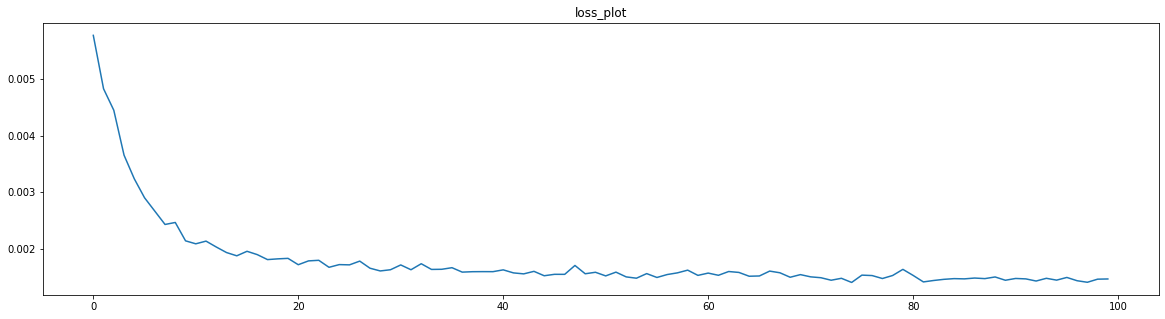

In [ ]:
'''Plot the learning progress'''

plt.rcParams['figure.figsize'] = (20,5)

_, ax = plt.subplots()

ax.plot(hist.history['loss'])

ax.set_title('loss_plot')

plt.plot()

## Save all Models

In [ ]:
filename_rf = 'bm_stacking_rf.sav'

filename_et = 'bm_stacking_et.sav'

filename_lgbm = 'bm_stacking_lgbm.sav'

filename_xgb = 'bm_stacking_xgb.sav'

filename_lstm = 'tm_stacking_lstm'


pickle.dump(rf_reg, open(filename_rf, 'wb'))

pickle.dump(et_reg, open(filename_et, 'wb'))

pickle.dump(lgb_reg, open(filename_lgbm, 'wb'))

pickle.dump(xgb_reg, open(filename_xgb, 'wb'))

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

model.save('./%s' % filename_lstm, options=save_locally)

print('all models safed!')

all models safed!
